In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
pip install kaggle


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
print(os.getcwd())


/Users/saatvikshrivastava/Downloads


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

2023-12-12 00:42:11.434152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import pathlib


In [6]:
dataset_path = "/Users/saatvikshrivastava/Downloads/leaf/disease/tea sickness dataset"
dataset_dir = pathlib.Path(dataset_path)

In [7]:
class_names = []
for x in os.walk(dataset_path):
    sub_dir = x[0]
    sub_dir_list = str(sub_dir).split('/')
    if len(sub_dir_list) > 4 and sub_dir_list[-1] != 'tea sickness dataset':
        x_class = sub_dir_list[-1]
        class_names.append(x_class)

print(class_names)


['white spot', 'Anthracnose', 'healthy', 'gray light', 'bird eye spot', 'algal leaf', 'brown blight', 'red leaf spot']


In [8]:
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 885 files belonging to 8 classes.
Using 708 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                     validation_split=val_split,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=val_batch
                                                    )


Found 885 files belonging to 8 classes.
Using 177 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


2023-12-12 00:43:45.383209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 279 of 1024
2023-12-12 00:43:55.527116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 559 of 1024
2023-12-12 00:44:00.334760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


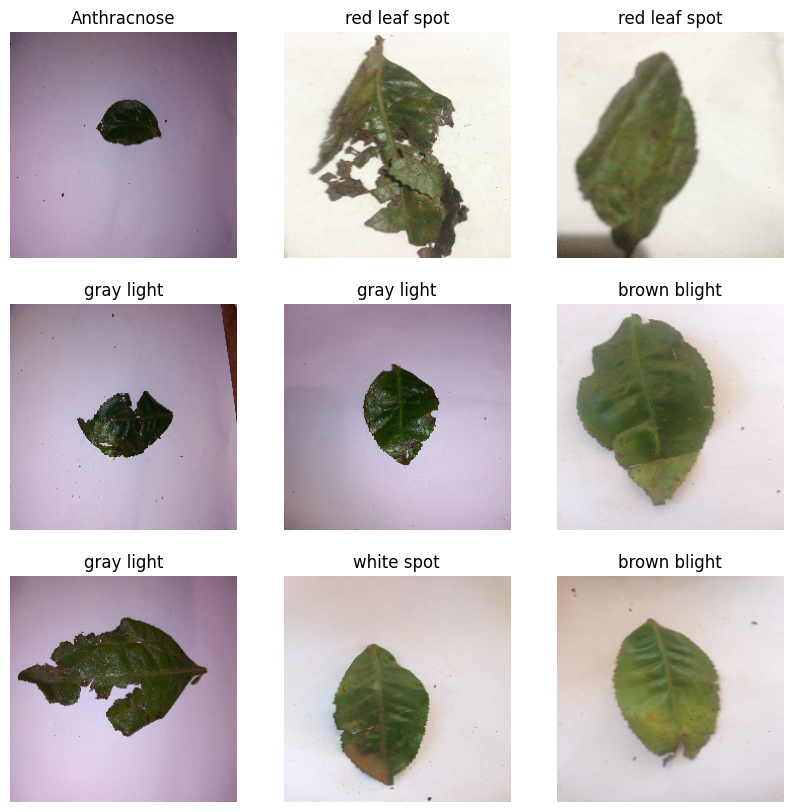

In [12]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),  # New augmentation (example)
    layers.RandomBrightness(0.2),  # New augmentation (example)
])

# Adjust model architecture
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),  # Increased filters
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),  # Increased filters
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),  # Increased filters
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),  # Increased units
    layers.Dropout(0.5),  # Adjusted dropout rate
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

# Adjust learning rate and optimizer
base_learning_rate = 0.0001  # Experiment with different values
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping]  # Implement early stopping
)


Epoch 1/50


2023-12-12 00:45:38.235996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 315 of 1024
2023-12-12 00:45:51.241278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-12-12 00:45:51.288274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 1 of 1000
2023-12-12 00:45:51.503342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6/6 [==============================] - 102s 12s/step - loss: 2.1876 - accuracy: 0.1568 - val_loss: 2.1055 - val_accuracy: 0.2090
Epoch 2/50
6/6 [==============================] - 62s 10s/step - loss: 2.1201 - accuracy: 0.1737 - val_loss: 2.1171 - val_accuracy: 0.1412
Epoch 3/50
6/6 [==============================] - 62s 10s/step - loss: 2.0554 - accuracy: 0.2006 - val_loss: 2.0705 - val_accuracy: 0.2429
Epoch 4/50
6/6 [==============================] - 59s 10s/step - loss: 2.0350 - accuracy: 0.2175 - val_loss: 2.0348 - val_accuracy: 0.1977
Epoch 5/50
6/6 [==============================] - 59s 10s/step - loss: 1.9869 - accuracy: 0.2062 - val_loss: 2.0137 - val_accuracy: 0.2655
Epoch 6/50
6/6 [==============================] - 60s 10s/step - loss: 1.9466 - accuracy: 0.2288 - val_loss: 1.9715 - val_accuracy: 0.2881
Epoch 7/50
6/6 [==============================] - 57s 9s/step - loss: 1.9295 - accuracy: 0.2429 - val_loss: 1.9551 - val_accuracy: 0.2316
Epoch 8/50
6/6 [======================

In [16]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [17]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze base layers
base_model.trainable = False

# Create new model on top of the pre-trained base model
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes)(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fine-tune the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1,
    callbacks=[early_stopping],  # Implement early stopping
)

# Evaluate the model
test_loss, test_acc = model.evaluate(val_ds)
print("Test accuracy:", test_acc)


16705208/16705208 [==============================] - 3s 0us/step


Epoch 1/30
6/6 [==============================] - 64s 10s/step - loss: 1.8615 - accuracy: 0.3037 - val_loss: 1.4780 - val_accuracy: 0.5198
Epoch 2/30
6/6 [==============================] - 50s 9s/step - loss: 1.3350 - accuracy: 0.5537 - val_loss: 1.1275 - val_accuracy: 0.6328
Epoch 3/30
6/6 [==============================] - 51s 9s/step - loss: 1.0113 - accuracy: 0.6497 - val_loss: 0.9250 - val_accuracy: 0.6667
Epoch 4/30
6/6 [==============================] - 51s 9s/step - loss: 0.8651 - accuracy: 0.7175 - val_loss: 0.8302 - val_accuracy: 0.7006
Epoch 5/30
6/6 [==============================] - 51s 9s/step - loss: 0.7781 - accuracy: 0.7232 - val_loss: 0.7736 - val_accuracy: 0.7175
Epoch 6/30
6/6 [==============================] - 51s 9s/step - loss: 0.6670 - accuracy: 0.7627 - val_loss: 0.7215 - val_accuracy: 0.7458
Epoch 7/30
6/6 [==============================] - 53s 9s/step - loss: 0.6027 - accuracy: 0.7994 - val_loss: 0.7544 - val_accuracy: 0.7175
Epoch 8/30
6/6 [=================

Predictions:
 [7 7 0 7 2 7 2 1 1 4 4 7 7 6 0 1 4 3 3 2 3 2 1 3 7 4 1 3 4 4 7 5 7 0 6 2 7
 7 4 4 7 7 6 0 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 7 5 3 7 7 2
 2 7 1 3 2 2 4 6 6 0 0 1 1 4 7 0 0 0 5 3 2 7 4 7 7 7 2 6 0 7 4 1 7 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 1 0 4 7 3 0]
Labels:
 [3 7 2 7 0 7 2 1 1 4 0 7 7 6 0 1 2 3 3 4 3 0 6 3 7 4 1 1 0 4 7 5 3 0 6 4 3
 7 4 4 7 7 6 2 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 2
 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 0]

              precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.86      0.92      0.89        13
           2       0.62      0.73      0.67        11
           3       0.94      0.65      0.77        23
           4       0.85      0.85      0.85        20
           5       1.00      1.00      1.00         7
           6       1.00      0.87      0.93        15
           7       0.

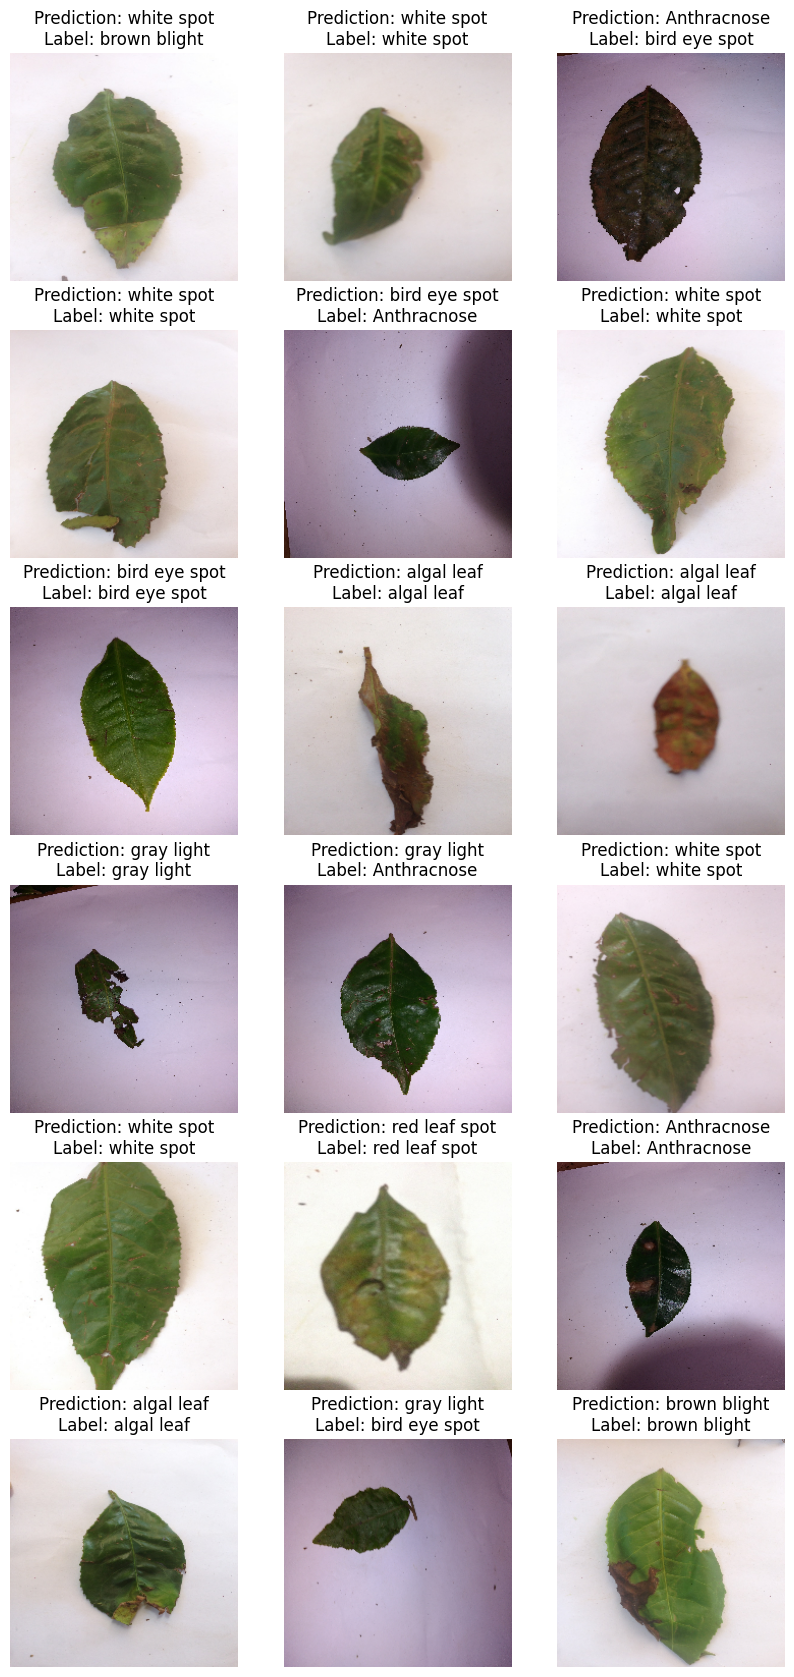

In [19]:
# Assuming you've trained and updated the 'model' variable with the new architecture and trained weights
import numpy as np

# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")
plt.show()


In [26]:
import pickle

# Assuming 'model' is your trained model
# Save the model to a file using pickle
model_filename = 'best.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

# Print a message indicating successful export
print(f"Model has been exported to {model_filename}")


Model has been exported to best.pkl


1/1 [==============================] - 0s 364ms/step
Predicted Class Index: 0
Predicted Class Name: Anthracnose
Raw Prediction Values:
Anthracnose: 4.184720039367676
algal leaf: -0.5643808841705322
bird eye spot: 1.1073293685913086
brown blight: -1.9066725969314575
gray light: -0.9068479537963867
healthy: -3.8738129138946533
red leaf spot: 1.4195449352264404
white spot: 0.9954119920730591


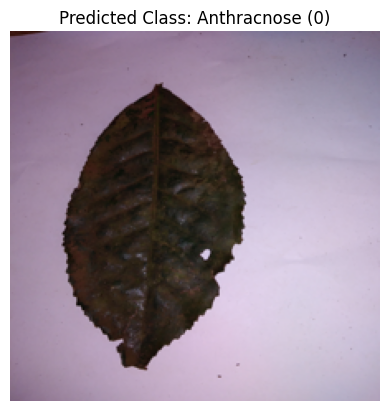

In [27]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is your trained and updated model for disease classification
# Assuming you have a list 'class_names' with class names in order

# Load the external image
external_image_path = '/Users/saatvikshrivastava/Downloads/leaf/disease/tea sickness dataset/bird eye spot/IMG_20220503_150405.jpg'
external_image = Image.open(external_image_path).resize((img_height, img_width))  # Assuming img_height and img_width are defined

# Convert the image to a NumPy array
external_image_array = np.array(external_image)

# Make prediction without normalization or preprocessing
predictions = model.predict(np.expand_dims(external_image_array, axis=0))

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Define a list of class names
class_names = ["Anthracnose", "algal leaf", "bird eye spot","brown blight","gray light","healthy","red leaf spot","white spot"]  # Replace with your class names

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class index and name
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Name:", predicted_class_name)

# Print raw prediction values for each class name
print("Raw Prediction Values:")
for class_name, prediction in zip(class_names, predictions[0]):
    print(f"{class_name}: {prediction}")

# Display the external image with the predicted class
plt.imshow(external_image)
plt.title(f"Predicted Class: {predicted_class_name} ({predicted_class_index})")
plt.axis("off")
plt.show()
